# Testing kloppy as a new data source

```
pip install kloppy
```
or
```
uv add kloppy
```
or just
```
uv sync
```

## Pros and Cons

Pros
- It's nice to have different data sources with a unified API
- I think that's about it, but it's kind of huge. We can pull data from so many different sources for free and see what's available.
- [Open Sources](https://kloppy.pysport.org/user-guide/loading-data/#supported-data-providers)
    - Impect
    - Metrica
    - PPF FC
    - SkillCorner
    - Sportec
    - StatsBomb
    - WyScout (woah really?)
- The following open sources have match event data
    - Sportec
    - StatsBomb
    - WyScout

Cons
- I don't like needing to know the match id beforehand, but maybe there's a way around it?
- It seems pretty unfriendly to new users
- Documentation is... not up to date

## Getting started

No literally - https://kloppy.pysport.org/user-guide/getting-started/

In [156]:
from kloppy import sportec

event_dataset = sportec.load_open_event_data(match_id="J03WN1")

In [157]:
# look at it as a pandas dataframe
event_dataset.to_df().head()

,event_id,event_type,period_id,timestamp,end_timestamp,ball_state,ball_owning_team,team_id,player_id,coordinates_x,coordinates_y,end_coordinates_x,end_coordinates_y,receiver_player_id,set_piece_type,result,success,body_part_type,card_type
0,18226900000006,PASS,1,0 days 00:00:00,None,alive,None,DFL-CLU-00000S,DFL-OBJ-000172,0.500000,0.500000,0.745238,0.501471,DFL-OBJ-0001I0,KICK_OFF,COMPLETE,True,None,None
1,18226900000007,PASS,1,0 days 00:00:04.110000,None,alive,None,DFL-CLU-00000S,DFL-OBJ-0001I0,0.745238,0.501471,0.275905,0.914853,None,None,COMPLETE,True,None,None
2,18226900000008,GENERIC:TacklingGame,1,0 days 00:00:06.365000,None,alive,None,None,None,0.275905,0.914853,NaN,NaN,None,None,None,None,None,None
3,18226900000009,FOUL_COMMITTED,1,0 days 00:00:06.765000,None,alive,None,DFL-CLU-00000B,DFL-OBJ-J01KDN,NaN,NaN,NaN,NaN,None,None,None,None,None,None
4,18226900000010,PASS,1,0 days 00:00:31.794000,None,alive,None,DFL-CLU-00000S,DFL-OBJ-0027LO,0.255714,0.930735,NaN,NaN,None,FREE_KICK,INCOMPLETE,False,None,None


In [158]:
from kloppy.domain import BodyPartQualifier

# search for shot data
shots_data = event_dataset.find_all("shot")
for event in shots_data:
    print(f"({event.timestamp})\t{event.player} shot ({event.get_qualifier_value(BodyPartQualifier).value}) --> {event.result}")
    # print(dir(event))
    # print(dir(event.get_qualifier_value(BodyPartQualifier)))
    # print(event.get_qualifier_value(BodyPartQualifier).value)




(0:00:52.374000)	S. Azmoun shot (RIGHT_FOOT) --> BLOCKED
(0:00:57.383000)	M. Diaby shot (RIGHT_FOOT) --> BLOCKED
(0:01:50.052000)	S. Azmoun shot (RIGHT_FOOT) --> BLOCKED
(0:02:03.819000)	Exequiel Palacios shot (RIGHT_FOOT) --> OFF_TARGET
(0:18:03.590000)	P. Förster shot (LEFT_FOOT) --> GOAL
(0:19:33.018000)	A. Losilla shot (LEFT_FOOT) --> OFF_TARGET
(0:22:41.590000)	M. Diaby shot (RIGHT_FOOT) --> OFF_TARGET
(0:26:47.843000)	S. Azmoun shot (RIGHT_FOOT) --> SAVED
(0:30:26.537000)	P. Hofmann shot (HEAD) --> OFF_TARGET
(0:31:15.766000)	T. Asano shot (LEFT_FOOT) --> OFF_TARGET
(0:33:37.790000)	T. Asano shot (RIGHT_FOOT) --> GOAL
(0:35:37.674000)	Florian Wirtz shot (RIGHT_FOOT) --> SAVED
(0:42:25.401000)	C. Antwi-Adjei shot (RIGHT_FOOT) --> OFF_TARGET
(0:44:56.186000)	P. Hofmann shot (LEFT_FOOT) --> SAVED
(0:06:12.057000)	M. Diaby shot (RIGHT_FOOT) --> OFF_TARGET
(0:15:27.726000)	N. Amiri shot (RIGHT_FOOT) --> BLOCKED
(0:16:43.771000)	Jeremie Frimpong shot (RIGHT_FOOT) --> POST
(0:20:27.1730

## Nice plots
```
pip install mplsoccer
```

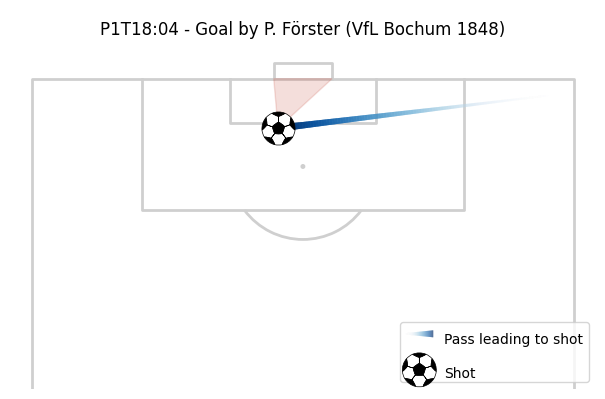

In [159]:
# literally copied and pasted code
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch
from kloppy.domain import PositionType


shot_events = event_dataset.find_all("shot")
goal_events = event_dataset.find_all("shot.goal")

goal_event = goal_events[0]
assist_event = goal_event.prev("pass.complete")

# Setup the pitch
pitch = VerticalPitch(
    half=True, goal_type='box', pad_bottom=-.2,
    line_color="#cfcfcf",
    line_zorder=1,
    pitch_type="metricasports",
    pitch_length=event_dataset.metadata.pitch_dimensions.pitch_length,
    pitch_width=event_dataset.metadata.pitch_dimensions.pitch_width,
)

# We will use mplsoccer's grid function to plot a pitch with a title axis.
fig, axs = pitch.grid(
    figheight=4, endnote_height=0,  # no endnote
    title_height=0.1, title_space=0.02,
    # Turn off the endnote/title axis. I usually do this after
    # I am happy with the chart layout and text placement
    axis=False,
    grid_height=0.83
)

# Plot the goal angle
pitch.goal_angle(
    1-assist_event.receiver_coordinates.x, 1-assist_event.receiver_coordinates.y,
    alpha=0.2, zorder=1.1, color='#cb5a4c', goal='right', ax=axs['pitch']
)
# Plot the assist
pitch.lines(
    1-assist_event.coordinates.x, 1-assist_event.coordinates.y,
    1-assist_event.receiver_coordinates.x, 1-assist_event.receiver_coordinates.y,
    lw=5, transparent=True, comet=True, cmap='Blues', zorder=1.2,
    label='Pass leading to shot', ax=axs['pitch']
)
# Plot the shot
pitch.scatter(
    1-assist_event.receiver_coordinates.x, 1-assist_event.receiver_coordinates.y,
    s=600, marker="football", zorder=1.3, label='Shot', ax=axs['pitch']
)

# Add a legend and title
legend = axs['pitch'].legend(loc='lower right', labelspacing=1.5)
for text in legend.get_texts():
    text.set_fontsize(10)
    text.set_va('center')

# Add a title
axs['title'].text(
    0.5, 0.5,
    f'{goal_event.time} - Goal by {goal_event.player} ({goal_event.team})',
    va='center', ha='center', color='black', fontsize=12
)

plt.show()

## Pattern Matching

https://kloppy.pysport.org/user-guide/getting-started/#pattern-matching

In [160]:
from kloppy import event_pattern_matching as pm

In [178]:
pattern = (
    # match all successful passes
    pm.match_pass(
        success=True,
        capture="first_touch"
    )
    # ... that are followed by 3 successful passes by the same team
    + pm.match_pass(
        success=True,
        team=pm.same_as("first_touch.team"),
    ) * 3
    # ... ending with a shot by the same team
    + pm.match_shot(
        team=pm.same_as("first_touch.team")
    )
)

In [179]:
shot_ending_chains = pm.search(event_dataset, pattern)
print(f"Found {len(shot_ending_chains)} matches!")

for chain in shot_ending_chains:
    print(" -> ".join([e.player.name for e in chain.events]) + f" ({chain.events[-1].result})")

Found 2 matches!
Jonathan Tah -> Jeremie Frimpong -> Florian Wirtz -> Jeremie Frimpong -> M. Diaby (OFF_TARGET)
P. Förster -> A. Losilla -> P. Hofmann -> K. Stöger -> C. Antwi-Adjei (OFF_TARGET)


## Data transformations

https://kloppy.pysport.org/user-guide/getting-started/#transforming-data

- oh my god this part is convoluted and horribly documented. Not all of the code in the tutorial works.

In [163]:
from kloppy import sportec
from kloppy.domain import Provider
import matplotlib.pyplot as plt
event_dataset = sportec.load_open_event_data(
    match_id='J03WN1'
    ).transform(to_coordinate_system=Provider.SPORTEC)

home_team, away_team = event_dataset.metadata.teams

In [164]:
event_dataset.metadata.coordinate_system.pitch_dimensions.y_dim.max

68.0

In [165]:
event_dataset.metadata.orientation

away-home

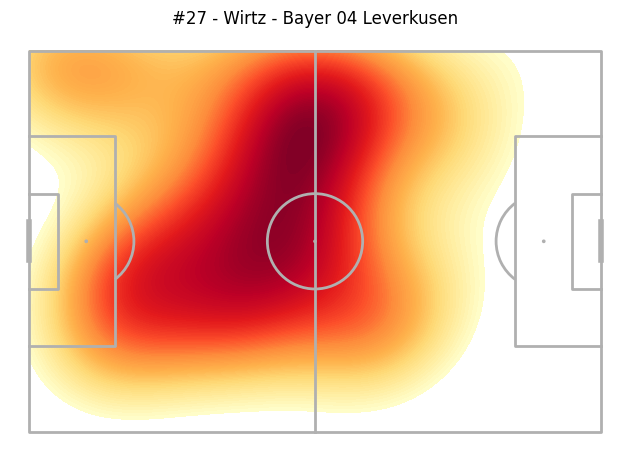

In [166]:
from mplsoccer import Pitch
from kloppy.domain import EventType

player = away_team.get_player_by_id("DFL-OBJ-002GBK")

player_events = event_dataset.filter(
    lambda event: event.event_type == EventType.PASS and event.player == player
)

def heatmap(xs, ys):
    # mplsoccer has horrible documentation
    # kloppy is slow with updating their docs
    pitch = Pitch(
        # pitch_type=event_dataset.metadata.coordinate_system.to_mplsoccer(),
        line_zorder=2,
    )
    fig, ax = pitch.draw()
    ax.set_title(f"#{player.jersey_no} - {player.last_name} - {player.team.name}")
    pitch.kdeplot(xs, ys, ax=ax, cmap="YlOrRd", fill=True, levels=100)

xs = [event.coordinates.x for event in player_events if event.coordinates is not None]
ys = [event.coordinates.y for event in player_events if event.coordinates is not None]

heatmap(xs, ys)
plt.show()

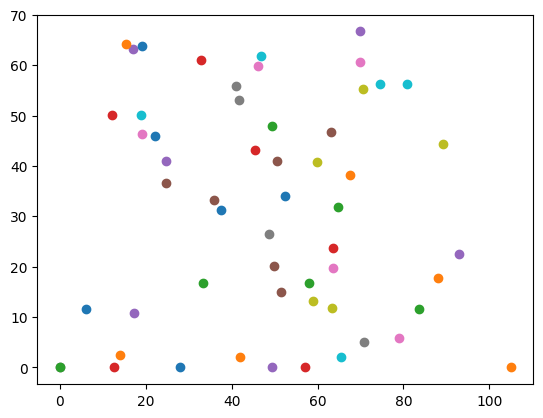

In [167]:
for event in player_events:
    plt.scatter(event.coordinates.x, event.coordinates.y)
plt.show()

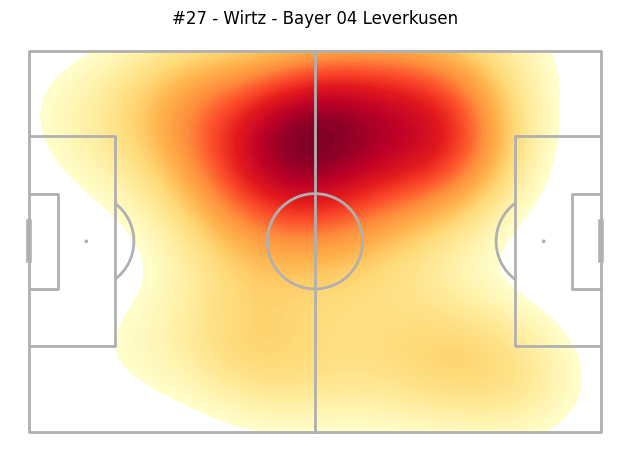

In [168]:
transformed_events = player_events.transform(to_orientation="ACTION_EXECUTING_TEAM")
xs = [
    event.coordinates.x for event in transformed_events if event.coordinates is not None
]
ys = [
    event.coordinates.y for event in transformed_events if event.coordinates is not None
]

heatmap(xs, ys)
plt.show()


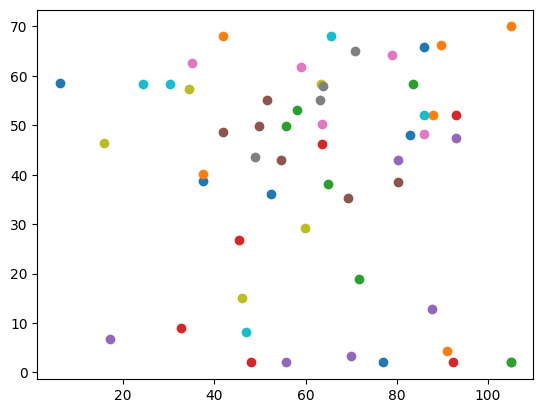

In [172]:
for event in transformed_events:
    plt.scatter(event.coordinates.x, 70-event.coordinates.y)
plt.show()